In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import re, multiprocessing, os

In [3]:
import spacy
from spacy.tokens.doc import Doc

In [4]:
from gensim.models import Word2Vec

### Data Import

Grab the data from: https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [5]:
train = pd.read_csv('data/labeledTrainData.tsv', sep='\t')

In [6]:
print(train.shape)

(25000, 3)


In [7]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


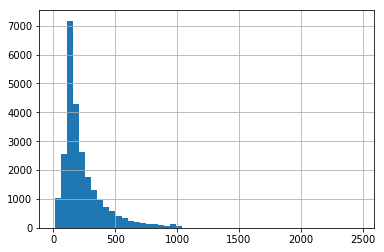

In [8]:
train['review'].apply(lambda x: len(x.split())).hist(bins=50)

### Write Text to Disk (Optional)

In [18]:
count = 0
USE_SPACY_POS = True
VERBOSE = False

with open('data/plain_text/train_sentences.txt', mode='a', encoding='utf-8') as f:
    for i, v in train['review'].iteritems():
        try:
            d = transform_doc(v) if USE_SPACY_POS else v
            for line in d.split('\n'):
                if len(line) > 0:
                    f.write(line+'\n')
        except Exception as e:
            print(e)
            if VERBOSE:
                print('could not parse: {}'.format(v))
        count += 1
        if count % 1000 == 0:
            print('Finished: {}'.format(count))

Finished: 1000
Finished: 2000
Finished: 3000
Finished: 4000
Finished: 5000
Finished: 6000
Finished: 7000
Finished: 8000
Finished: 9000
Finished: 10000
Finished: 11000
Finished: 12000
Finished: 13000
Finished: 14000
Finished: 15000
Finished: 16000
Finished: 17000
Finished: 18000
Finished: 19000
Finished: 20000
Finished: 21000
Finished: 22000
Finished: 23000
Finished: 24000
Finished: 25000


### Train W2V Model

Use generator if data is too big for memory, otherwise just put in a list and iterate.

In [9]:
class ParsedSentenceGenerator(object):
    def __init__(self, dirname, verbose=False):
        self.dirname = dirname
        self.verbose = verbose
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            if fname[-4:] == '.txt':
                for line in open(os.path.join(self.dirname, fname), encoding='utf-8'):
                    try:
                        yield line.split()
                    except Exception as e:
                        print(e)
                        if verbose:
                            print('Line Failed: ' + line)
                        pass

In [10]:
s = ParsedSentenceGenerator(dirname='data/plain_text/')

In [11]:
N_WORKERS = multiprocessing.cpu_count() - 1
print('Number of workers: '+ str(N_WORKERS))
EMBED_SIZE = 128

Number of workers: 11


In [12]:
w2v_model = Word2Vec(sentences=s,
                     size=EMBED_SIZE,
                     window=9,
                     min_count=3,
                     sample=0.001,
                     seed=42,
                     workers=N_WORKERS,
                     sg=0,
                     hs=0,
                     negative=7,
                     iter=14,
                     compute_loss=True
            )

In [13]:
len(w2v_model.wv.vocab)

67600

In [14]:
w2v_model.most_similar(positive='movie|NOUN')

[('film|NOUN', 0.8124839663505554),
 ('musical|ADJ', 0.5818781852722168),
 ('flick|NOUN', 0.5752246975898743),
 ('story|NOUN', 0.5630144476890564),
 ('picture|NOUN', 0.5519418120384216),
 ('a_movie|NOUN', 0.5515578985214233),
 ('a_film|NOUN', 0.5457206964492798),
 ('show|NOUN', 0.5457108616828918),
 ('documentary|NOUN', 0.5343351364135742),
 ('western|ADJ', 0.5341377258300781)]

In [17]:
w2v_model.most_similar(positive='good|ADJ')

[('great|ADJ', 0.7268439531326294),
 ('cool|ADJ', 0.7122242450714111),
 ('bad|ADJ', 0.7072707414627075),
 ('solid|ADJ', 0.6796900629997253),
 ('decent|ADJ', 0.6787437200546265),
 ('impressive|ADJ', 0.6651002168655396),
 ('lousy|ADJ', 0.6095108985900879),
 ('poor|ADJ', 0.6048907041549683),
 ('glamorous|ADJ', 0.600853443145752),
 ('good.<br|ENT', 0.5982713103294373)]

In [15]:
w2v_model.save('models/w2v_model_'+str(EMBED_SIZE))

Useful Docs:
* https://radimrehurek.com/gensim/models/word2vec.html

Useful Papers:
* word2vec Parameter Learning Explained: https://arxiv.org/abs/1411.2738
* Comparative study of word embedding methods in topic segmentation https://ac.els-cdn.com/S1877050917313480/1-s2.0-S1877050917313480-main.pdf?_tid=610efaa2-171a-11e8-a5b4-00000aacb360&acdnat=1519226450_2f4ec995830aa2e27b566f56ad81af8e

### Helper Functions

In [10]:
nlp = spacy.load('en_core_web_sm')

LABELS = {
    'ENT': 'ENT',
    'PERSON': 'ENT',
    'NORP': 'ENT',
    'FAC': 'ENT',
    'ORG': 'ENT',
    'GPE': 'ENT',
    'LOC': 'ENT',
    'LAW': 'ENT',
    'PRODUCT': 'ENT',
    'EVENT': 'ENT',
    'WORK_OF_ART': 'ENT',
    'LANGUAGE': 'ENT',
    'DATE': 'DATE',
    'TIME': 'TIME',
    'PERCENT': 'PERCENT',
    'MONEY': 'MONEY',
    'QUANTITY': 'QUANTITY',
    'ORDINAL': 'ORDINAL',
    'CARDINAL': 'CARDINAL'
}


pre_format_re = re.compile(r'^[\`\*\~]')
post_format_re = re.compile(r'[\`\*\~]$')
url_re = re.compile(r'\[([^]]+)\]\(%%URL\)')
link_re = re.compile(r'\[([^]]+)\]\(https?://[^\)]+\)')


def strip_meta(text):
    if type(text) == str:
        text = link_re.sub(r'\1', text)
        text = text.replace('&gt;', '>').replace('&lt;', '<')
        text = pre_format_re.sub('', text)
        text = post_format_re.sub('', text)
        return text
    else:
        return ''
    

def represent_word(word):
    if word.like_url:
        return '%%URL|X'
    text = re.sub(r'\s', '_', word.text)
    tag = LABELS.get(word.ent_type_, word.pos_)
    if not tag:
        tag = '?'
    return text + '|' + tag


def merge_clean_sentence(nlp, text, collapse_punctuation=True, collapse_phrases=True):
    doc = nlp(text)
    if collapse_punctuation:
        spans = []
        for word in doc[:-1]:
            if word.is_punct:
                continue
            if not word.nbor(1).is_punct:
                continue
            start = word.i
            end = word.i + 1
            while end < len(doc) and doc[end].is_punct:
                end += 1
            span = doc[start : end]
            spans.append(
                (span.start_char, span.end_char,
                 {'tag': word.tag_, 'lemma': word.lemma_, 'ent_type': word.ent_type_})
            )
        for start, end, attrs in spans:
            doc.merge(start, end, **attrs)

    if collapse_phrases:
        for np in list(doc.noun_chunks):
            np.merge(tag=np.root.tag_, lemma=np.root.lemma_, ent_type=np.root.ent_type_)
    
    return doc


def transform_doc(text):
    d = merge_clean_sentence(nlp, text, collapse_punctuation=False, collapse_phrases=True)
    strings = []
    for sent in d.sents:
        if sent.text.strip():
            strings.append(' '.join(represent_word(w) for w in sent if not w.is_space))
    if strings:
        return '\n'.join(strings) + '\n'
    else:
        return ''

Example:

In [40]:
sentence = "George Clinton is a musician.  He was born in 1941.  He is not related to Bill Clinton, who was the former President of the United States of America."
print(sentence)

George Clinton is a musician.  He was born in 1941.  He is not related to Bill Clinton, who was the former President of the United States of America.


In [42]:
print(transform_doc(sentence))

George_Clinton|ENT is|VERB a_musician|NOUN .|PUNCT
He|PRON was|VERB born|VERB in|ADP 1941|DATE .|PUNCT
He|PRON is|VERB not|ADV related|VERB to|ADP Bill_Clinton|ENT ,|PUNCT who|NOUN was|VERB the_former_President|PROPN of|ADP the_United_States|ENT of|ENT America|ENT .|PUNCT

